In [1]:
import copy
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import xgboost as xg

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from utils.file_utils import (open_json, write_json, save_submission,
                              log_whole_dataset_training, log_kfold_training)
from utils.models import SimpleNN
from utils.model_utils import *



/home/ml/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DIR_PATH = "./dataset"
config = open_json(f"{DIR_PATH}/config.json")
features_dict = open_json(f"{DIR_PATH}/features.json")
features = compute_feature_list(config, features_dict)

LOG_NAME = "XGBoost"
COMPUTE_LEARNING_CURVE = True
COMPUTE_FEATURE_IMPORTANCE = True
TRAIN_WHOLE_DATASET = False
COMPUTE_SUBMISSION = False


In [3]:
if torch.cuda.is_available() and config["use_cuda"]:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cpu


In [4]:
def k_fold_training(df, ksplit, config, features, device, keep_models=False):
    training_results = []
    model_list = [None]*config["k-fold"]
    scaler_list = [None]*config["k-fold"]

    for k in range(config["k-fold"]):
        train, test = next(ksplit)
        df_train = df[df["protein_index"].isin(train)]
        df_test = df[df["protein_index"].isin(test)]

        # we load the data for training
        scaler = StandardScaler()

        # we load the data
        X_train, y_train = prepare_xgboost(
            df_train, config, features, scaler, fit_scaler=True)
        X_test, y_test = prepare_xgboost(
            df_test, config, features, scaler, fit_scaler=False)

        # Initialize a new Novozymes Model
        model = xg.XGBRegressor(objective='reg:squarederror',
                                n_estimators=config["n_estimators"], seed=123)

        # Fitting the model
        model.fit(X_train, y_train)

        # Evaluate this model:
        y_train_predicted = model.predict(X_train)
        y_test_predicted = model.predict(X_test)
        train_mse = mean_squared_error(y_train, y_train_predicted)
        test_mse = mean_squared_error(y_test, y_test_predicted)

        results = {
            "train_mse": train_mse,
            "test_mse": test_mse
        }
        training_results.append(results)

        if keep_models:
            model_list[k] = copy.deepcopy(model)
            scaler_list[k] = copy.deepcopy(scaler)

    # Process is complete.

    return training_results, model_list, scaler_list


## Learning Curve

In [5]:
if COMPUTE_LEARNING_CURVE:
    df = pd.read_csv(f"{DIR_PATH}/{config['dataset_name']}.csv")

    # plot the learning curve of the model
    # ie. the avg mse when df has 10, 100, 1000 elements
    # len(df) = 5k
    num_rows = [100, 1000, 3000, len(df)]
    all_training_results = {"training_by_num_rows": [],
                            "learning_curve": {"num_rows": num_rows,
                                            "train_mse": [],
                                            "test_mse": []
                                            },
                            "total_training_time": 0
                            }

    for n in num_rows:
        print(f"training on {n} rows from the dataset")
        df_n_rows = df.sample(n)
        # add protein_index to the dataset and get ksplit:
        df_n_rows, ksplit = split_dataset(df_n_rows, config)
        training_results, _, _ = k_fold_training(
            df_n_rows, ksplit, config, features, device)

        # add training results to all the other ones
        all_training_results["training_by_num_rows"].append(training_results)
        # compute avg_mse and time
        train_mse = sum(x['train_mse']
                            for x in training_results)/config['k-fold']
        test_mse = sum(x['test_mse']
                        for x in training_results)/config['k-fold']

        # update result variables
        all_training_results["learning_curve"]["train_mse"].append(train_mse)
        all_training_results["learning_curve"]["test_mse"].append(test_mse)




training on 100 rows from the dataset
training on 1000 rows from the dataset
training on 3000 rows from the dataset
training on 5487 rows from the dataset


logged training in ./outputs/XGBoost_3


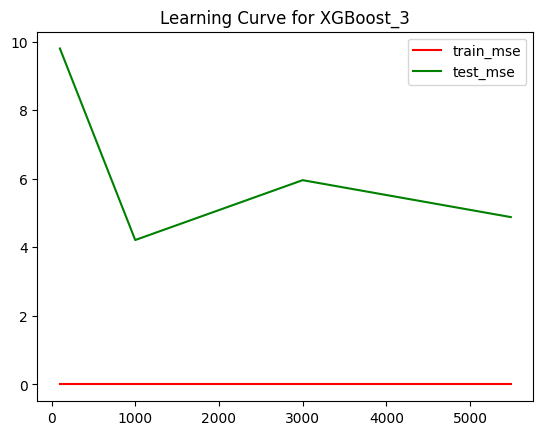

In [6]:
if COMPUTE_LEARNING_CURVE:
    # save results to output
    model = SimpleNN(len(features))
    model_structure = str(model).replace('(', '').replace(')', '').split('\n')
    dir_path = log_kfold_training(
        LOG_NAME, all_training_results, config, features, model_structure)
    print(f"logged training in {dir_path}")

## Feature Importance

In [7]:
if COMPUTE_FEATURE_IMPORTANCE and False:
    # all_training_results[feature1]: result obtained when df[feature1] = random
    all_training_results = {}
    
    df = pd.read_csv(f"{DIR_PATH}/{config['dataset_name']}.csv")

    # 1. we train k-fold models using all features:
    df, ksplit = split_dataset(df, config)
    ksplit_list = list(ksplit)
    training_results, model_list, scaler_list = k_fold_training(
        df, iter(ksplit_list), config, features, device, keep_models=True)

    # compute mse (with no feature randomized)
    none_random_train_mse = sum(x['train_mse']
                                for x in training_results)/config['k-fold']
    none_random_test_mse = sum(x['test_mse']
                                for x in training_results)/config['k-fold']
    all_training_results["none_randomized"] = {
        "train_mse": none_random_train_mse, "test_mse": none_random_test_mse}
    
    # 2. for each feature we take the df, randomize the feature column, then compute the new mse score with each model
    for feature in features:
        # create a copy of the dataset with the feature column being random
        df_random = copy.deepcopy(df)
        df_random[feature] = np.random.randint(-1000, 1000, df_random.shape[0])
        training_results = []

        # evaluate all model on this new dataset
        ksplit = iter(ksplit_list)
        for k in range(config["k-fold"]):
            # get the same ksplit as during training
            train, test = next(ksplit)
            model = model_list[k] # model result from the training
            scaler = scaler_list[k] # scaler from training

            # we load the data for evaluation
            df_train = df_random[df_random["protein_index"].isin(train)]
            df_test = df_random[df_random["protein_index"].isin(test)]
            # we load the data
            X_train, y_train = prepare_xgboost(
                df_train, config, features, scaler, fit_scaler=True)
            X_test, y_test = prepare_xgboost(
                df_test, config, features, scaler, fit_scaler=False)

            # Evaluate this model:
            y_train_predicted = model.predict(X_train)
            y_test_predicted = model.predict(X_test)
            train_mse = mean_squared_error(y_train, y_train_predicted)
            test_mse = mean_squared_error(y_test, y_test_predicted)

            results = {
                "train_mse": train_mse,
                "test_mse": test_mse
            }
            training_results.append(results)
                
        # compute avg_mse
        train_mse = sum(x['train_mse']
                        for x in training_results)/config['k-fold']
        test_mse = sum(x['test_mse']
                    for x in training_results)/config['k-fold']
        # add training results to all the other ones
        all_training_results[feature] = {
            "train_mse": train_mse, "test_mse": test_mse, 
            "delta_train_mse": train_mse-none_random_train_mse,
            "delta_test_mse": test_mse-none_random_test_mse,
            }

    # rank results
    ranked_delta_test_mse = [[x, all_training_results[x].get(
        "delta_test_mse", 0)] for x in all_training_results.keys()]
    ranked_delta_test_mse.sort(key=lambda x: x[1], reverse=True)
    ranked_delta_test_mse = {x[0]: x[1] for x in ranked_delta_test_mse}
    write_json(f"./outputs/{LOG_NAME}_feature_importance.json",
               {"ranked_delta_test_mse": ranked_delta_test_mse,
                "all_training_results": all_training_results})


# Predicting on submission

In [8]:
def whole_dataset_training(df, config, features, device):
    """
    This function is to be sure to use all available data for submission
    This end up seeing the test dataset from kaggle as the test set, without a cv split
    This is not best practice for generalisation, 
    but we are trying to get the highest LB score afterall...
    """

    training_results = []

    # we load the data for training
    dataset_train = prepare_train_data(df, config, features)
    trainloader = torch.utils.data.DataLoader(dataset_train,
                                                batch_size=config["batch_size"],
                                                shuffle=False,
                                                num_workers=config["num_workers"])

    # we load the data for evaluation
    X_train, y_train = prepare_eval_data(
        df, config, features, dataset_train.scaler)
    
    # Initialize a new Novozymes Model
    model = SimpleNN(len(features))
    model.to(torch.double)
    model.to(device)

    # Define the loss function and optimizer
    loss_function = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Train model:
    model, loss_over_time, mse_over_time, _ = train_model(
        model, config, optimizer, loss_function, trainloader, device)

    # Evaluate this model:
    model.eval()
    with torch.set_grad_enabled(False):
        train_mse = evaluate_model(X_train, y_train, model, device)
        # print(f"MSE obtained for k-fold {k}: {mse}")
        results = {
            "loss_over_time": loss_over_time,
            "mse_over_time": mse_over_time,
            "train_mse": train_mse
        }
    
    # Process is complete.

    return model, results, dataset_train.scaler


In [9]:
if TRAIN_WHOLE_DATASET:
    df = pd.read_csv(f"{DIR_PATH}/{config['dataset_name']}.csv")
    model, results, train_scaler = whole_dataset_training(
        df, config, features, device)

    # save results to output
    model_structure = str(model).replace('(', '').replace(')', '').split('\n')
    dir_path = log_whole_dataset_training(LOG_NAME+"_whole_dataset", results,
                            config, features, model_structure)
    print(f"logged training in {dir_path}")


In [10]:
if TRAIN_WHOLE_DATASET and COMPUTE_SUBMISSION:
    df_test = pd.read_csv(f"{DIR_PATH}/processed_test.csv")
    X_test = df_test[features]
    X_test = train_scaler.transform(X_test)
    X_test = torch.from_numpy(X_test)
    X_test = X_test.to(device)
    y_test = model(X_test)
    submission = pd.DataFrame(columns=["seq_id", "tm"])
    submission["seq_id"] = df_test["seq_id"]
    submission["tm"] = y_test.detach().numpy() * -1
    print(submission.head())
    save_path = save_submission(submission, LOG_NAME)
    print(f"{save_path=}")
